In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image

1. LOAD DATA

In [6]:
base_path = "C:/Users/achma/OneDrive - UGM 365/01. Projects/MTI/#2 SMT/CV/Project_UAS/PROJECT_Data/"
csv_path = os.path.join(base_path, "C:/Users/achma/OneDrive - UGM 365/01. Projects/MTI/#2 SMT/CV/Project_UAS/ISIC_2017_Data_GroundTruth_Classification.csv")
df = pd.read_csv(csv_path)

In [7]:
def load_image(image_path):
    try:
        with Image.open(image_path) as img:
            return np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_images(base_path, image_ids):
    original_images = {}
    binary_images = {}
    superpixel_images = {}

    for img_id in image_ids:
        originalfilename = f"ISIC_{img_id}.jpg"
        original_path = os.path.join(base_path, originalfilename)
        original_img = load_image(original_path)
        if original_img is not None:
            original_images[img_id] = original_img

        binaryfilename = f"ISIC_{img_id}_segmentation.png"
        binary_path = os.path.join(base_path, binaryfilename)
        binary_img = load_image(binary_path)
        if binary_img is not None:
            binary_images[img_id] = binary_img

        superpixelfilename = f"ISIC_{img_id}_superpixels.png"
        superpixel_path = os.path.join(base_path, superpixelfilename)
        superpixel_img = load_image(superpixel_path)
        if superpixel_img is not None:
            superpixel_images[img_id] = superpixel_img

    return original_images, binary_images, superpixel_images


In [8]:
availableimages = [f"ISIC_{img_id.split('_')[-1]}.jpg" for img_id in df['image_id']]
available_images = [originalfilename for originalfilename in availableimages if os.path.exists(os.path.join(base_path, originalfilename))]
availableids = [originalfilename.split('.')[0].split('_')[-1] for originalfilename in available_images]

original_images, binary_images, superpixel_images = load_images(base_path, availableids)

In [9]:
print(f"Count original: {len(original_images)}")
print(f"Count binary: {len(binary_images)}")
print(f"Count superpixel: {len(superpixel_images)}")

Count original: 200
Count binary: 200
Count superpixel: 200


2. FEATURES EXTRACTION

In [10]:
from skimage.measure import regionprops, label
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import kurtosis, skew

In [11]:
def extract_geometric_features(binary_image):
    labeled_img = label(binary_image)
    regions = regionprops(labeled_img)

    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        return {
            'area': largest_region.area,
            'perimeter': largest_region.perimeter,
            'eccentricity': largest_region.eccentricity,
            'equivalent_diameter': largest_region.equivalent_diameter,
            'extent': largest_region.extent,
            'solidity': largest_region.solidity,
        }
    else:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0,
            'equivalent_diameter': 0, 'extent': 0, 'solidity': 0
        }

def extract_texture_features(image, is_superpixel=False):
    if len(image.shape) == 3:
        image = np.mean(image, axis=2).astype(np.uint8) 

    glcm = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()

    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    lbp_entropy = -np.sum(hist * np.log2(hist + 1e-7))

    if is_superpixel:
        unique_values = np.unique(image)
        return {
            'num_superpixels': len(unique_values),
            'superpixel_variation': np.std(unique_values),
        }
    else:
        return {
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation,
            'lbp_entropy': lbp_entropy,
            'mean_intensity': np.mean(image),
            'std_intensity': np.std(image),
            'kurtosis': kurtosis(image.ravel()),
            'skewness': skew(image.ravel())
        }

def extract_all_features(original_image, binary_image, superpixel_image):
    geometric_features = extract_geometric_features(binary_image)
    texture_features_original = extract_texture_features(original_image)
    texture_features_superpixel = extract_texture_features(superpixel_image, is_superpixel=True)

    all_features = {**geometric_features, **texture_features_original, **texture_features_superpixel}

    return all_features

In [12]:
dataset = []
for img_id in availableids:
    if img_id in original_images and img_id in binary_images and img_id in superpixel_images:
        item = {
            'original_image': original_images[img_id],
            'binary_image': binary_images[img_id],
            'superpixel_image': superpixel_images[img_id],
            'melanoma': df.loc[df['image_id'] == f'ISIC_{img_id}', 'melanoma'].values[0]
        }
        features = extract_all_features(item['original_image'], item['binary_image'], item['superpixel_image'])
        item['features'] = features
        dataset.append(item)

In [13]:
print("\nExample for the first picture:")
for key, value in dataset[0]['features'].items():
    print(f"{key}: {value}")

feature_names = list(dataset[0]['features'].keys())
X = np.array([list(item['features'].values()) for item in dataset])
y = np.array([item['melanoma'] for item in dataset])

print(f"\nSize picture matrix: {X.shape}")
print(f"Count features: {len(feature_names)}")
print(f"Feature names: {feature_names}")


Example for the first picture:
area: 364956.0
perimeter: 2586.8855685242374
eccentricity: 0.7571807388984642
equivalent_diameter: 681.6717768019782
extent: 0.7319262610704659
solidity: 0.9688342854715739
contrast: 10.478260590764505
dissimilarity: 1.5410770892065262
homogeneity: 0.5625499366651052
energy: 0.07724085726514854
correlation: 0.9988838721438769
lbp_entropy: 3.967610412436776
mean_intensity: 149.97988197082694
std_intensity: 68.58369399090007
kurtosis: -1.5124072679466303
skewness: -0.45019357371909974
num_superpixels: 86
superpixel_variation: 24.82438317461282

Size picture matrix: (200, 18)
Count features: 18
Feature names: ['area', 'perimeter', 'eccentricity', 'equivalent_diameter', 'extent', 'solidity', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_entropy', 'mean_intensity', 'std_intensity', 'kurtosis', 'skewness', 'num_superpixels', 'superpixel_variation']


In [14]:
feature_df = pd.DataFrame(columns=['image_id'] + feature_names + ['melanoma'])

for img_file in available_images:
    img_id = img_file.split('.')[0].split('_')[-1]
    item = dataset[availableids.index(img_id)]
    feature_values = list(item['features'].values())
    feature_row = [img_id] + feature_values + [item['melanoma']]
    feature_df.loc[len(feature_df)] = feature_row

feature_df = feature_df.set_index('image_id')

print(feature_df)

              area    perimeter  eccentricity  equivalent_diameter    extent  \
image_id                                                                       
0000000   364956.0  2586.885569      0.757181           681.671777  0.731926   
0000001    53432.0  1068.915872      0.436456           260.828939  0.749923   
0000002   237402.0  2421.010460      0.597147           549.790519  0.642384   
0000003   260712.0  2187.655121      0.433660           576.150005  0.707612   
0000004   269484.0  2014.410388      0.666933           585.762482  0.757791   
...            ...          ...           ...                  ...       ...   
0000511   369118.0  3594.269478      0.725531           685.547689  0.612461   
0000513   193598.0  1788.285497      0.554615           496.484269  0.743284   
0000516   273920.0  2389.897762      0.851266           590.563948  0.569705   
0000517   563610.0  3338.042856      0.699698           847.118964  0.770801   
0000518   123361.0  1583.491557      0.5

In [15]:
feature_df.to_csv('feature_table.csv')

3. CLASSIFICATION & TESTING

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc

feature_df = pd.read_csv('feature_table.csv')

X = feature_df.drop('melanoma', axis=1)
y = feature_df['melanoma']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, nb_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")

F1 score: 0.75
Confusion matrix:
[[20  1]
 [ 7 12]]
Accuracy: 0.80
ROC AUC: 0.90


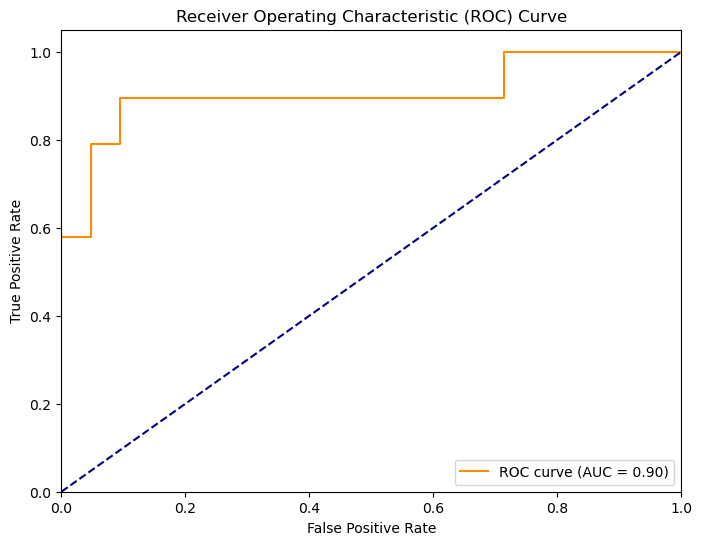

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()